## Preprocessing audio data sample





In [1]:
import numpy as np
import librosa, librosa.display
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Text(0.5, 1.0, 'Waveform')

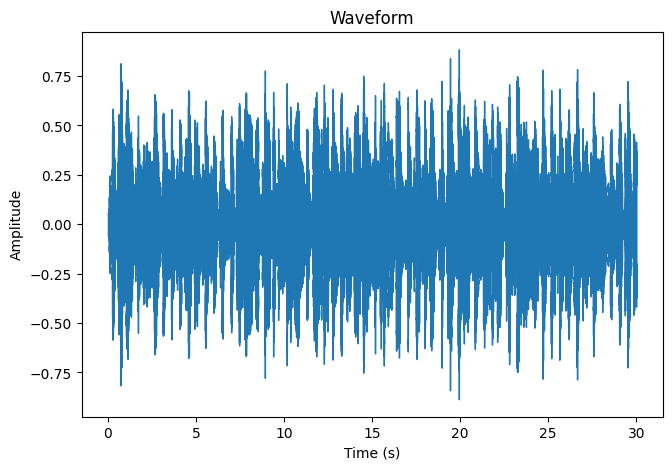

In [3]:
FIG_SIZE = (7.5,5)

file = "/content/drive/MyDrive/Colab-Notebooks/AI-2024/Data/genres_original/blues/blues.00000.wav"

# load audio file usig Librosa
signal, sample_rate = librosa.load(file, sr=22050)

# Show waveform
plt.figure(figsize=FIG_SIZE)
librosa.display.waveshow(signal, sr=sample_rate)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Waveform")

Text(0.5, 1.0, 'Power spectrum')

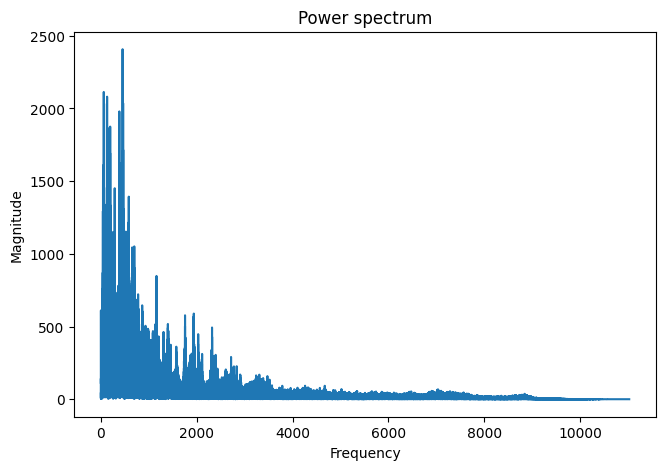

In [4]:
# Fourier transform
fft = np.fft.fft(signal)

magnitude = np.abs(fft)
frequency = np.linspace(0, sample_rate, len(magnitude))

left_magnitude = magnitude[:int(len(magnitude)/2)]
left_frequency = frequency[:int(len(frequency)/2)]

# plot spectrum
plt.figure(figsize=FIG_SIZE)
plt.plot(left_frequency, left_magnitude)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.title("Power spectrum")

Text(0.5, 1.0, 'Spectrogram (dB)')

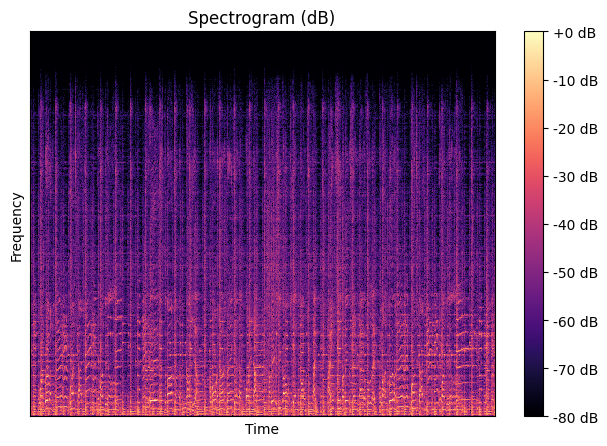

In [6]:
# Spectrogram
n_fft = 2048
hop_length = 512

stft = np.abs(librosa.stft(signal, n_fft=n_fft, hop_length=hop_length))

log_spectrogram = librosa.amplitude_to_db(stft, ref=np.max)

plt.figure(figsize=FIG_SIZE)
librosa.display.specshow(log_spectrogram, sr=sample_rate, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar(format="%+2.0f dB")
plt.title("Spectrogram (dB)")

Text(0.5, 1.0, 'Mel Spectrogram')

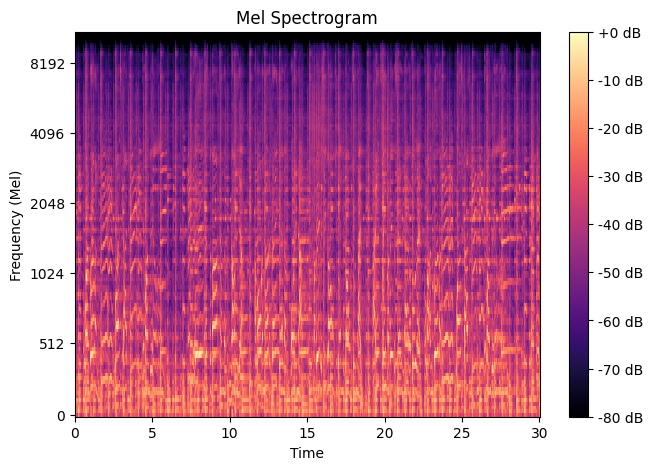

In [7]:
# Mel spectrogram
n_fft = 2048
hop_length = 512
n_mels = 128

mel_spectrogram = librosa.feature.melspectrogram(y=signal, sr=sample_rate, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)

# Convert Mel spectrogram to dB scale (log scale)
mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)

# Display Mel spectrogram
plt.figure(figsize=FIG_SIZE)
librosa.display.specshow(mel_spectrogram_db, sr=sample_rate, hop_length=hop_length, x_axis='time', y_axis='mel')
plt.xlabel("Time")
plt.ylabel("Frequency (Mel)")
plt.colorbar(format='%+2.0f dB')
plt.title("Mel Spectrogram")

## Music genre classification: Preparing the dataset

In [8]:
import json
import os
import math
import librosa

DATASET_PATH = "/content/drive/MyDrive/Colab-Notebooks/AI-2024/Data/genres_original"
OUTPUT_DIR = "/content/drive/MyDrive/Colab-Notebooks/AI-2024/Data/json_output"

SAMPLE_RATE = 22050
TRACK_DURATION = 30  # in secs
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION

In [9]:
def dump_to_json(data, json_path):
    print("\nDumping data to file:", json_path)
    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)


In [10]:
def get_mel_spectrogram_dictionary(dataset_path, output_dir, n_mels=128, n_fft=2048, hop_length=512, num_segments=10):
    samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    num_mel_vectors_per_segment = math.ceil(samples_per_segment / hop_length)


    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
        if dirpath != dataset_path:
            # Save genre label (i.e., sub-folder name)
            genre_label = dirpath.split("/")[-1]
            genre_json_path = os.path.join(output_dir, genre_label + ".json")

            # Skip if JSON file already exists for this genre
            if os.path.exists(genre_json_path):
                print("JSON file already exists fo {}.".format(genre_label))
                continue

            genre_data = {"mel_spectrograms": []}
            processed_segments = 0  # Counter for processed segments
            print("\nProcessing: {}".format(genre_label))

            # Process all audio files in genre sub-dir
            for f in filenames:
                file_path = os.path.join(dirpath, f)
                signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)
                audio_length = librosa.get_duration(y=signal, sr=sample_rate)

                if audio_length < TRACK_DURATION:
                    # Calculate the amount of padding needed
                    padding_length = int((TRACK_DURATION - audio_length) * sample_rate)

                    # Pad the audio file with zeros
                    padded_signal = np.pad(signal, (0, padding_length), mode='constant')
                    signal = padded_signal

                elif audio_length > TRACK_DURATION:
                    # Trim the audio file to 30 seconds
                    signal = signal[:int(TRACK_DURATION * sample_rate)]

                # Process all segments of audio file
                for d in range(num_segments):
                    start = samples_per_segment * d
                    finish = start + samples_per_segment

                    # Extract mel-spectrogram
                    mel_spectrogram = librosa.feature.melspectrogram(
                        y=signal[start:finish],
                        sr=sample_rate,
                        n_mels=n_mels,
                        n_fft=n_fft,
                        hop_length=hop_length
                    )
                    mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
                    mel_spectrogram = mel_spectrogram.T

                    # Store only mel-spectrogram feature with expected number of vectors
                    if len(mel_spectrogram) == num_mel_vectors_per_segment:
                        genre_data["mel_spectrograms"].append(mel_spectrogram.tolist())
                        processed_segments += 1  # Increment the counter
                    else:
                        print("Unexpected mel-spectrogram length:", len(mel_spectrogram))

            # Print the number of processed segments for the genre
            print("Processed segments for {}: {}".format(genre_label, processed_segments))

            # Dump genre data to a separate JSON file
            dump_to_json(genre_data, genre_json_path)



In [11]:
# Call the function to process the dataset and save mel spectrograms for each genre to separate JSON files
get_mel_spectrogram_dictionary(DATASET_PATH, OUTPUT_DIR, num_segments=10)

JSON file already exists fo blues.


## Music genre classification: Implementing a CNN

In [12]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import matplotlib.pyplot as plt

In [14]:
import os
import json
import numpy as np

def load_data(data_dir):
    X = []
    y = []
    label_list = []  # List to store genre labels

    # Iterate over each genre file in the data directory
    for file_name in os.listdir(data_dir):
        if file_name.endswith(".json"):
            genre_label = file_name.split(".")[0]  # Extract genre label from the file name
            label_list.append(genre_label)

            file_path = os.path.join(data_dir, file_name)

            # Load data from the JSON file
            with open(file_path, "r") as fp:
                genre_data = json.load(fp)

            # Add mel spectrograms to X and assign labels to y
            for mel_spectrogram in genre_data["mel_spectrograms"]:
                X.append(mel_spectrogram)
                y.append(label_list.index(genre_label))  # Append the index of the genre label

    # Convert lists to numpy arrays
    X = np.array(X)
    y = np.array(y)

    print("Data successfully loaded!")

    return X, y, label_list


In [15]:
from sklearn.model_selection import train_test_split

def prepare_datasets(train_size, val_size, test_size):
    X, y, label_list = load_data(OUTPUT_DIR)

    # create train, validation and test split with stratification
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42, stratify=y)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=val_size/(train_size+val_size), random_state=42, stratify=y_train)

    # add an axis to input sets
    X_train = X_train[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_validation, X_test, y_train, y_validation, y_test, label_list


In [16]:
def build_model(input_shape):
    """Generates CNN model

    :param input_shape (tuple): Shape of input set
    :return model: CNN model
    """

    # build network topology
    model = keras.Sequential()

    # 1st conv layer
    model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((2, 2)))
    model.add(keras.layers.BatchNormalization())

    # 2nd conv layer
    model.add(keras.layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2)))
    model.add(keras.layers.BatchNormalization())

    # 3rd conv layer
    model.add(keras.layers.Conv2D(256, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2)))
    model.add(keras.layers.BatchNormalization())

    # Flatten output and feed it into dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(512, activation='relu'))
    model.add(keras.layers.Dropout(0.5))  # Increased dropout rate

    # Additional dropout layer
    model.add(keras.layers.Dropout(0.5))

    # Output layer
    model.add(keras.layers.Dense(10, activation='softmax'))

    return model


In [17]:
def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs """

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")


    # Adjust spacing between subplots
    plt.subplots_adjust(hspace=0.5)

    plt.show()

In [18]:
X_train, X_validation, X_test, y_train, y_validation, y_test, label_list = prepare_datasets(train_size=0.7, val_size=0.2, test_size=0.1)
input_shape = (X_train.shape[1], X_train.shape[2], 1)

Data successfully loaded!


In [29]:
model = build_model(input_shape)

optimiser = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 128, 126, 64)      640       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 64, 63, 64)        0         
 g2D)                                                            
                                                                 
 batch_normalization_3 (Bat  (None, 64, 63, 64)        256       
 chNormalization)                                                
                                                                 
 conv2d_4 (Conv2D)           (None, 62, 61, 128)       73856     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 31, 30, 128)       0         
 g2D)                                                            
                                                      

In [30]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

# Define callbacks
callbacks = [
   EarlyStopping(patience=10, monitor='val_accuracy', restore_best_weights=True),
   ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, min_lr=1e-6),
   ModelCheckpoint(filepath='best_weights.h5',
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')
]

# Train the model with callbacks
history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation),
                    callbacks=callbacks, epochs=100)

# Load the best weights after training
model.load_weights('best_weights.h5')

print("Training completed !")



Epoch 1/100
218/219 [============================>.] - ETA: 0s - loss: 2.1501 - accuracy: 0.3551
Epoch 1: val_accuracy improved from -inf to 0.47626, saving model to best_weights.h5
219/219 [==============================] - 13s 47ms/step - loss: 2.1481 - accuracy: 0.3556 - val_loss: 1.4747 - val_accuracy: 0.4763 - lr: 1.0000e-04
Epoch 2/100
219/219 [==============================] - ETA: 0s - loss: 1.3369 - accuracy: 0.5529
Epoch 2: val_accuracy improved from 0.47626 to 0.70015, saving model to best_weights.h5
219/219 [==============================] - 10s 45ms/step - loss: 1.3369 - accuracy: 0.5529 - val_loss: 0.9208 - val_accuracy: 0.7001 - lr: 1.0000e-04
Epoch 3/100
219/219 [==============================] - ETA: 0s - loss: 1.0302 - accuracy: 0.6545
Epoch 3: val_accuracy improved from 0.70015 to 0.74013, saving model to best_weights.h5
219/219 [==============================] - 10s 46ms/step - loss: 1.0302 - accuracy: 0.6545 - val_loss: 0.7948 - val_accuracy: 0.7401 - lr: 1.0000e-0

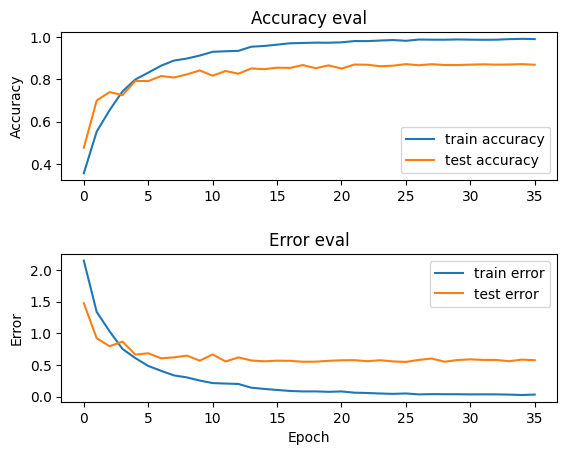

In [31]:
plot_history(history)

In [35]:

import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

# Get predictions for the test set
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)

# Convert one-hot encoded labels to class indices (if needed)
if len(y_test.shape) > 1:
    true_labels = np.argmax(y_test, axis=1)
else:
    true_labels = y_test



32/32 - 0s - loss: 0.5726 - accuracy: 0.8670 - 368ms/epoch - 12ms/step
Test loss: 0.5725728869438171
Test accuracy: 0.8669999837875366
32/32 [==============================] - 0s 9ms/step


In [36]:
# Print classification report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=label_list))

Classification Report:
              precision    recall  f1-score   support

      reggae       0.88      0.84      0.86       100
       metal       0.88      0.92      0.90       100
        rock       0.77      0.72      0.75       100
       blues       0.89      0.86      0.87       100
     country       0.80      0.82      0.81       100
        jazz       0.91      0.92      0.92       100
         pop       0.81      0.90      0.85       100
       disco       0.87      0.89      0.88       100
   classical       0.94      0.97      0.96       100
      hiphop       0.91      0.83      0.87       100

    accuracy                           0.87      1000
   macro avg       0.87      0.87      0.87      1000
weighted avg       0.87      0.87      0.87      1000



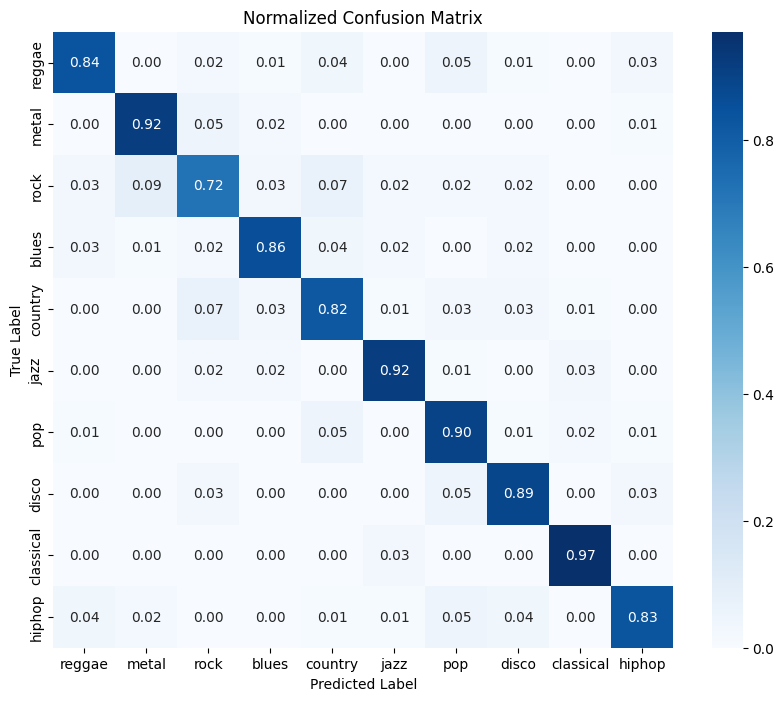

In [34]:
# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Compute the total number of samples for each true label
total_samples_per_class = np.sum(cm, axis=1)

# Normalize the confusion matrix
normalized_cm = cm / total_samples_per_class[:, np.newaxis]

# Plot the normalized confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(normalized_cm, annot=True, cmap='Blues', fmt=".2f", xticklabels=label_list, yticklabels=label_list)
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [ ]:
model_path = os.path.join(OUTPUT_DIR, "trained_model.keras")
model.save(model_path)

## GitHub Commit

In [ ]:
%cd /content/drive/MyDrive/Colab-Notebooks/AI-2024/Music-Genre-Classification


In [ ]:

!git config --global user.name "AyaSafan"
!git config --global user.email "ayasafan16@gmail.com"

!git rm -r --cached .
!git reset
!git add .
!git commit -m "remove dataloaders"
!git push origin master --force
